Reference https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('daily-minimum-temperatures-in-me.csv', header=0, index_col=0, squeeze=True, parse_dates=[0])

In [3]:
print data.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64


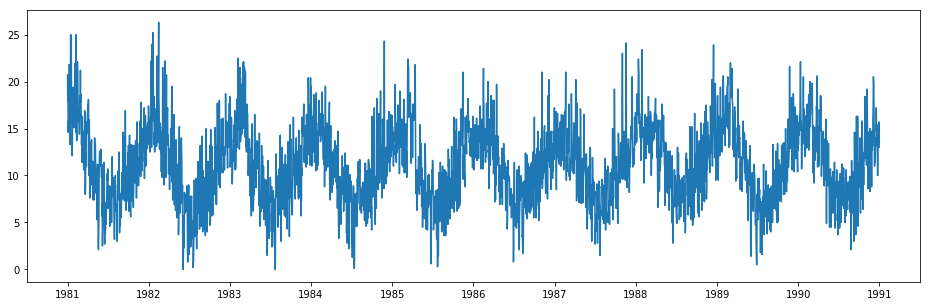

In [4]:
plt.figure(figsize=(16, 5))
plt.plot(data)
plt.show()

In [5]:
from pandas.plotting import lag_plot

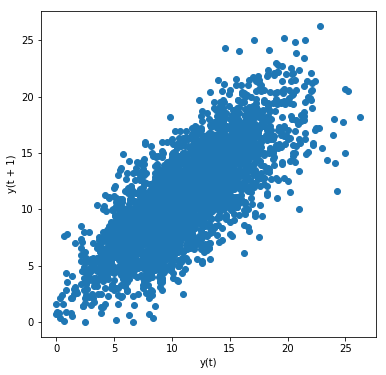

In [6]:
plt.figure(figsize=(6, 6))
lag_plot(data)
plt.show()

In [7]:
m_values = pd.DataFrame(data.values)

In [8]:
dataframe = pd.concat([m_values.shift(1), m_values], axis=1)

In [9]:
dataframe.corr()

,0,0
0,1.00000,0.77487
0,0.77487,1.00000


In [10]:
from pandas.plotting import autocorrelation_plot

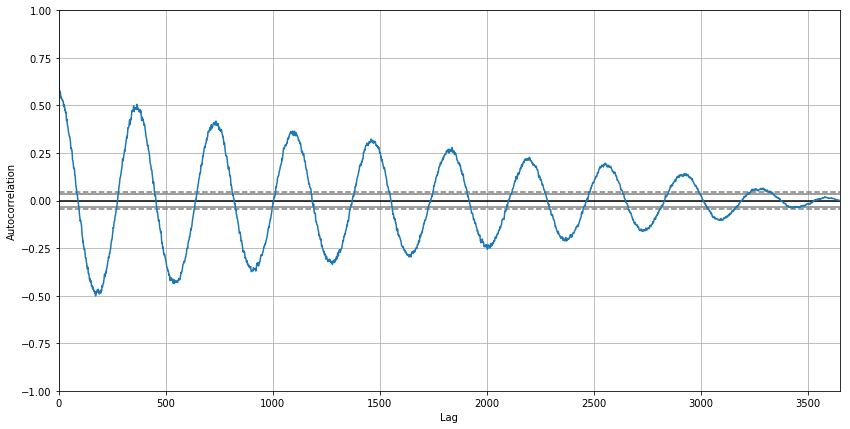

In [11]:
plt.figure(figsize=(14, 7))
autocorrelation_plot(data)
plt.show()

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


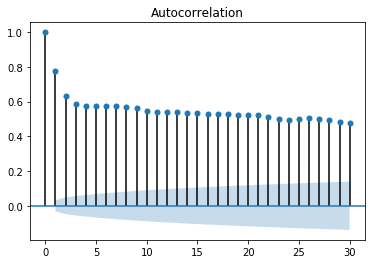

In [13]:
plot_acf(data, lags=30)
plt.show()

## Persistence Model

In [14]:
from sklearn.metrics import mean_squared_error

In [16]:
X =dataframe.values
X

array([[  nan,  20.7],
       [ 20.7,  17.9],
       [ 17.9,  18.8],
       ..., 
       [ 13.6,  13.5],
       [ 13.5,  15.7],
       [ 15.7,  13. ]])

In [17]:
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [18]:
test_X

array([ 10. ,  12.9,  14.6,  14. ,  13.6,  13.5,  15.7])

In [19]:
test_y

array([ 12.9,  14.6,  14. ,  13.6,  13.5,  15.7,  13. ])

In [22]:
round(mean_squared_error(test_y, test_X), 2)

3.42

## Autoregression Model

In [24]:
from statsmodels.tsa.ar_model import AR

In [29]:
data.values

array([ 20.7,  17.9,  18.8, ...,  13.5,  15.7,  13. ])

In [30]:
X = data.values
train, test = X[1:len(X)-7], X[len(X)-7:]

In [32]:
print train.shape, test.shape

(3642,) (7,)


In [31]:
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 29
Coefficients: [  5.57543506e-01   5.88595221e-01  -9.08257090e-02   4.82615092e-02
   4.00650265e-02   3.93020055e-02   2.59463738e-02   4.46675960e-02
   1.27681498e-02   3.74362239e-02  -8.11700276e-04   4.79081949e-03
   1.84731397e-02   2.68908418e-02   5.75906178e-04   2.48096415e-02
   7.40316579e-03   9.91622149e-03   3.41599123e-02  -9.11961877e-03
   2.42127561e-02   1.87870751e-02   1.21841870e-02  -1.85534575e-02
  -1.77162867e-03   1.67319894e-02   1.97615668e-02   9.83245087e-03
   6.22710723e-03  -1.37732255e-03]


In [33]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [34]:
predictions

array([ 11.87127485,  13.05379422,  13.53259095,  13.24312646,
        13.09143803,  13.14698884,  13.17615346])

In [35]:
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=11.871275, expected=12.900000
predicted=13.053794, expected=14.600000
predicted=13.532591, expected=14.000000
predicted=13.243126, expected=13.600000
predicted=13.091438, expected=13.500000
predicted=13.146989, expected=15.700000
predicted=13.176153, expected=13.000000
Test MSE: 1.502


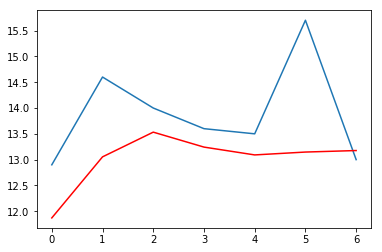

In [37]:
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Rolling AR Model

In [38]:
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

In [87]:
# walk forward over time steps in test
history = train[len(train)-window:]
history= list(history)

In [90]:
coef.shape

(30,)

In [88]:
predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * history[window-d-1] # coefficients from t-1 to t-n
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    history = history[1:]
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=11.871275, expected=12.900000
predicted=13.659297, expected=14.600000
predicted=14.349246, expected=14.000000
predicted=13.427454, expected=13.600000
predicted=13.374877, expected=13.500000
predicted=13.479991, expected=15.700000
predicted=14.765146, expected=13.000000
Test MSE: 1.451


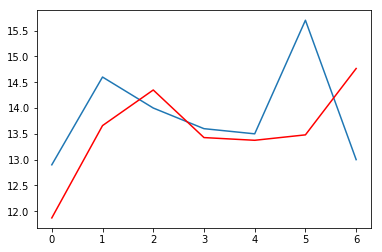

In [84]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()